In [75]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as PLT
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,Dropout,LSTM,GRU,BatchNormalization,Activation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import deque
from sklearn import preprocessing
import datetime as dt
import pandas_datareader as web 
import requests
from cryptocmd import CmcScraper
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [ ]:
# DF = pd.read_csv('../../../datasets/foolad.csv')
# DF = DF.sort_values(by='<DTYYYYMMDD>').reset_index(drop=True)
# DF['<DTYYYYMMDD>'] = DF['<DTYYYYMMDD>'].apply(lambda date: ''.join([ f'{v}-' if i in [3,5] else v for (i,v) in enumerate(str(date)) ]))
# DF['<DTYYYYMMDD>'] = pd.to_datetime(DF['<DTYYYYMMDD>'])
# DF.rename(columns={
#     '<DTYYYYMMDD>' : 'Date',
#     '<FIRST>':'Open',
#     '<HIGH>':'High',
#     '<LOW>':'Low',
#     '<CLOSE>':'Close',
#     '<VALUE>':'Volume',
# },inplace=True)
# DF.set_index('Date',inplace=True)
# DF = DF[['Open','High','Low','Close','Volume']]
# DF.head()

In [29]:
# start = dt.datetime(2018,1,1)
# end = dt.datetime.now()
# DOGE = web.DataReader('DOGE-USD', 'yahoo', start, end)


# DOGE = DOGE.reset_index()
# DOGE['Date'] = pd.to_datetime(DOGE['Date'])
# DOGE = DOGE.rename(columns={'Date':'Date'})
# DOGE.drop(columns=['Adj Close'],inplace=True)
# DOGE.set_index('Date',inplace=True)

In [237]:
SYMBOL = 'DOGE'
start = dt.datetime(2018,1,1)
end = dt.datetime.now()
scraper = CmcScraper(SYMBOL,'01-01-2018','19-12-2022')
DF = scraper.get_dataframe()

In [238]:
DF = DF.reset_index(drop=True)
DF['Date'] = pd.to_datetime(DF['Date'])
# DF.drop(columns=['Market Cap'],inplace=True)
DF.set_index('Date',inplace=True)
DF= DF.iloc[::-1]
DF.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2018-01-01,0.009031,0.009063,0.008101,0.008909,50616900.0,1.003050e+09
2018-01-02,0.008873,0.009598,0.008551,0.009145,89424096.0,1.029797e+09
2018-01-03,0.009088,0.009584,0.008882,0.009320,66349900.0,1.049588e+09
2018-01-04,0.009346,0.010036,0.008768,0.009644,108986000.0,1.086239e+09
2018-01-05,0.009660,0.012283,0.009589,0.012167,212383008.0,1.370605e+09


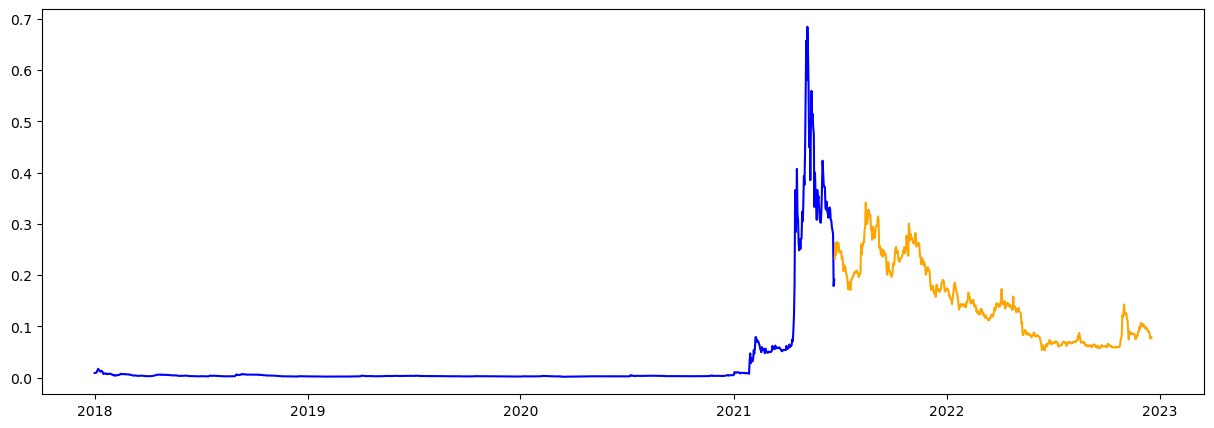

In [239]:
DF_train, DF_test = train_test_split(DF,test_size=.3,shuffle=False)
PLT.figure(figsize=(15,5))
PLT.plot(DF_train['Close'], c='blue',label='train_data')
PLT.plot(DF_test['Close'], c='orange',label='test_data')

In [240]:
def extract_window_data(DF,window):
    window_data = []
    for i in range(len(DF)- window):
        tmp = DF[i:(i+window)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

In [701]:
def prepare_data(DF,TARGET_COL,window):
    X = extract_window_data(
        DF,
        window
    )
    Y = DF[TARGET_COL][window:].values

    return DF, X, Y

In [799]:
window = 10
DF_train, DF_test = train_test_split(DF,test_size=.1,shuffle=False)

DF_train = (DF_train/DF_train.std())
# DF_train, X_train, Y_train = prepare_data(DF_train,'Close',window)
X_train, Y_train = DF_train[DF_train.columns.difference(['Close'])], DF_train['Close']
Y_train[Y_train > 1] = 1
Y_train[Y_train < 1] = 0

DF_test = (DF_test/DF_train.std())
# DF_test, X_test, Y_test = prepare_data(DF_test,'Close',window)
X_test, Y_test = DF_test_int[DF_test.columns.difference(['Close'])], DF_test_int['Close']

Y_test[Y_test > 1] = 1
Y_test[Y_test < 1] = 0

In [801]:
model = Sequential()
model.add( 
    LSTM(units=32,
         input_shape=(X_train.shape[1],1),
         activation='relu',
        ) 
) 
model.add(Dropout(.5))
# model.add(Dense(10))
# model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

model_checkpoint_callback = ModelCheckpoint(
    filepath=f'{SYMBOL}_best_model',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True
)

early_stopping_callback = EarlyStopping(monitor='val_accuracy',mode='max',patience=50)

In [802]:
history = model.fit(
    X_train,Y_train,
    epochs=400,
    batch_size=50,
    validation_data=(X_test,Y_test),
    shuffle=True,
    callbacks=[model_checkpoint_callback,early_stopping_callback]
)

Epoch 1/400
33/33 [==============================] - 2s 15ms/step - loss: 1.1584 - accuracy: 0.0000e+00 - val_loss: 12520087228438806528.0000 - val_accuracy: 0.5974
Epoch 2/400
33/33 [==============================] - 0s 7ms/step - loss: 0.5153 - accuracy: 0.0000e+00 - val_loss: 188584504852698103808.0000 - val_accuracy: 0.5974
Epoch 3/400
33/33 [==============================] - 0s 8ms/step - loss: 0.2452 - accuracy: 0.0000e+00 - val_loss: 111982928324334714880.0000 - val_accuracy: 0.5974
Epoch 4/400
33/33 [==============================] - 0s 7ms/step - loss: 0.1751 - accuracy: 0.0000e+00 - val_loss: 78954751314129584128.0000 - val_accuracy: 0.5974
Epoch 5/400
33/33 [==============================] - 0s 8ms/step - loss: 0.1700 - accuracy: 0.0000e+00 - val_loss: 11375064615365902336.0000 - val_accuracy: 0.5974
Epoch 6/400
33/33 [==============================] - 0s 8ms/step - loss: 0.1372 - accuracy: 0.0000e+00 - val_loss: 6724160666443186176.0000 - val_accuracy: 0.5974
Epoch 7/400
33

Epoch 51/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0668 - accuracy: 0.0000e+00 - val_loss: 5550500173513228288.0000 - val_accuracy: 0.5974


In [788]:
Y_predict = model.predict(X_test)
Y_predict[Y_predict > 0.5] = 1
Y_predict[Y_predict <= 0.5] = 0
# Y_predict = [np.argmax(x) for x in Y_predict]
print(metrics.classification_report(Y_test,Y_predict))
print(metrics.accuracy_score(Y_test,Y_predict))
print(metrics.confusion_matrix(Y_test,Y_predict))

17/17 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       219
           1       0.60      1.00      0.75       325

    accuracy                           0.60       544
   macro avg       0.30      0.50      0.37       544
weighted avg       0.36      0.60      0.45       544

0.5974264705882353
[[  0 219]
 [  0 325]]


/home/masoud/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/masoud/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/masoud/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [784]:
start = 205
display(DF_test[start:start+1])
display(DF_test[start+1:start+2])

TTT = (
DF_test[start:start+1].reset_index(drop=True) / DF_test[start-1:start].reset_index(drop=True)
).astype(int)

Y_predict = model.predict(np.array(TTT.values.reshape(TTT.shape[0],TTT.shape[1],1)),verbose=False)
np.round(Y_predict)[0][0]

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2022-01-14,0.172053,0.203232,0.171283,0.183549,5.784005e+09,2.435153e+10


,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2022-01-15,0.183644,0.1936,0.182676,0.185103,1.878282e+09,2.455769e+10


0.0

array([[[1],
        [1],
        [1],
        [1],
        [0],
        [1]]])